In [ ]:
#pip install optuna

In [ ]:
#pip install --upgrade jupyter

In [ ]:
#pip install --upgrade ipywidgets

In [ ]:
#pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample
import sklearn
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans


#undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids

print(sklearn.__version__)
import random
#import optuna

1.2.1


In [2]:
#np.random.seed(12)

In [3]:
url = "https://github.com/kainath56/researchproject/raw/main/dataset_binarymixture_final.xlsx"
raw = pd.read_excel(url)
df = raw.copy()
df = df.dropna()
df = df.drop(columns=['Unnamed: 0', 'Solvent 1', 'Solvent 2', 'T'])
df2 =  df.copy()

print(df.head())

#converting each column into variables
q1 = df2.pop('q1')
q2 = df2.pop('q2')
r1 = df2.pop('r1')
r2 = df2.pop('r2')
x1 = df2.pop('x1')
x2 = df2.pop('x2')
ismisc = df2.pop('ismisc')


      q1     q2      r1      r2        x1        x2  ismisc
0  1.432  2.588  1.4311  2.5755  0.312852  0.132230       1
1  1.432  2.588  1.4311  2.5755  0.362349  0.564846       1
2  1.432  2.588  1.4311  2.5755  0.507916  0.181390       1
3  1.432  2.588  1.4311  2.5755  0.044826  0.656056       1
4  1.432  2.588  1.4311  2.5755  0.255614  0.554332       1


In [4]:
features = np.array((q1, q2,r1,r2, x1, x2)) #this gives a (dimension, samples) dataset
features=features.transpose() #this gives (samples,dimension)
print(features)

label = np.array(ismisc) 
label=label.reshape(-1,1) 
print(label.shape)



[[1.432      2.588      1.4311     2.5755     0.31285183 0.13223011]
 [1.432      2.588      1.4311     2.5755     0.36234932 0.56484608]
 [1.432      2.588      1.4311     2.5755     0.50791602 0.18138989]
 ...
 [2.968      1.4        3.9228     0.92       0.37997633 0.27343852]
 [2.968      1.4        3.9228     0.92       0.48989037 0.17757086]
 [2.968      1.4        3.9228     0.92       0.23414613 0.4340254 ]]
(18432, 1)


In [5]:
scalar = StandardScaler()
scalar.fit(features);
x = scalar.transform(features)
y=label #no need to do scaling of y because it is a binary variable


print(f"1s {np.count_nonzero(y == 1)} \n 0s {np.count_nonzero(y == 0)}")
under=RandomUnderSampler(random_state=12, sampling_strategy=0.7)
#x, y = under.fit_resample(x, y)
print(f"1s {np.count_nonzero(y == 1)} \n 0s {np.count_nonzero(label == 0)}")


1s 16457 
 0s 1975
1s 16457 
 0s 1975


In [6]:
Xtrain, Xtest, ytrain, ytest= train_test_split(x,y, test_size=0.3, shuffle=True, random_state=12, stratify=y) #turning shuffle on because currently the data is ordered by ismisc column
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=2765/15667, shuffle=True, random_state=12, stratify=ytrain)
#print(Xtrain.shape, Xtest.shape, Xval.shape,ytrain.shape, ytest.shape, yval.shape)



(12902, 6) (5530, 6) (12902, 1) (5530, 1)


## SVC model


def objective(trial):
  Cparam=trial.suggest_float('C', 0.001, 1)
  #gamma = trial.suggest_float('gamma', 0.0001,10)
  #z = trial.suggest_float('0', 0, 10)
  #o = trial.suggest_float('1',0,10)


  SVCmodel = SVC(kernel='linear', C=Cparam, class_weight='balanced', probability=True)
  SVCmodel.fit(Xtrain, ytrain.ravel())
  SVCytest = SVCmodel.predict(Xtest)
  mcc=matthews_corrcoef(ytest, SVCytest.ravel())
  return mcc

def SVM_optuna():
  #run hyperparameter optimisation with optuna
  study = optuna.create_study(direction = 'maximize')
  study.optimize(objective, n_trials=100)
  best_params = study.best_params
  print(best_params)

SVM_optuna()


In [10]:
def modeleval(ytestt, ypred):
  accuracy = accuracy_score(ytestt, ypred)
  mcc = matthews_corrcoef(ytestt, SVCypred.ravel())
  print("Prediction accuracy:", accuracy)
  print("Prediction mcc:", mcc)
  print("Classification report:\n", classification_report(ytestt,ypred))
  cfm = confusion_matrix(ytestt,ypred)
  disp = ConfusionMatrixDisplay(cfm)
  disp.plot()
  plt.gca().invert_yaxis()
  plt.show()

In [7]:
###################fitting the model##########################################
%time
SVCmodel = SVC(kernel='linear', C=1, random_state=12, class_weight='balanced')
SVCmodel.fit(Xtrain, ytrain.ravel())

CPU times: total: 0 ns
Wall time: 0 ns


SVC(C=1, class_weight='balanced', kernel='linear', random_state=12)

In [8]:
SVCytrain = SVCmodel.predict(Xtrain)
SVCytest = SVCmodel.predict(Xtest)
SVCy = SVCmodel.predict(x)

print("training:", matthews_corrcoef(ytrain.ravel(), SVCytrain))
print("testing:", matthews_corrcoef(y.ravel(), SVCy))
print("all data:", matthews_corrcoef(ytest.ravel(), SVCytest))


training: 0.949980742771786
testing: 0.9547195486674405
all data: 0.9657757435431985


#kfold
scorer = make_scorer(matthews_corrcoef)
scores_test = cross_val_score(SVCmodel, Xtest, ytest.ravel(), cv=10, scoring=scorer)
print(scores_test)
print("mean", scores_test.mean())
print("max", max(scores_test))


In [20]:
#stratified kfold
scorer = make_scorer(matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold 
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
accuracy = []
for train_index, test_index in skf.split(Xtest,ytest.ravel()):
    x1_train, x1_test = Xtest[train_index], Xtest[test_index]
    y1_train, y1_test = ytest[train_index], ytest[test_index]
    SVCmodel.fit(x1_train,y1_train.ravel())
    prediction = SVCmodel.predict(x1_test)
    score = matthews_corrcoef(prediction, y1_test.ravel())
    print("Score", score)
    accuracy.append(score)

print("Average score,", sum(accuracy)/len(accuracy))
print("Max score", max(accuracy))

Score 0.9586952367149086
Score 0.9662613538449494
Score 0.9724424335799288
Average score, 0.9657996747132622
Max score 0.9724424335799288


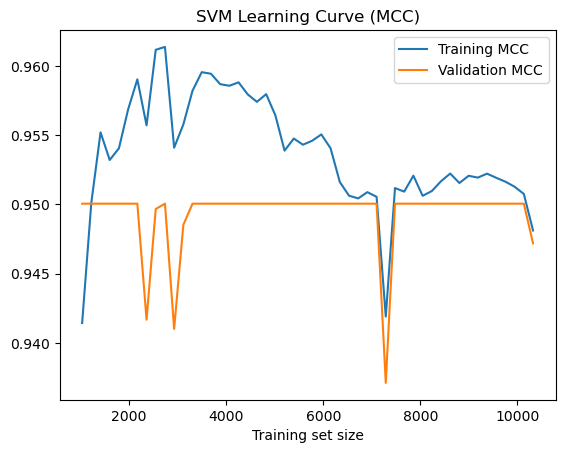

In [21]:

train_sizes = np.linspace(0.1, 1.0, 50)

train_sizes, train_scores, val_scores = learning_curve(
    SVCmodel, Xtrain, ytrain.ravel(), train_sizes=train_sizes, 
    cv=5, scoring=make_scorer(matthews_corrcoef))

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
plt.plot(train_sizes, train_mean, label='Training MCC') 
plt.plot(train_sizes, val_mean, label='Validation MCC')

plt.legend()
plt.xlabel('Training set size')  
plt.title('SVM Learning Curve (MCC)')
plt.show()

# creating gdx file

In [10]:
x_sv = SVCmodel.support_vectors_
y_sv = SVCmodel.predict(x_sv)*2-1  #map the y to -1,1

w_sv = SVCmodel.coef_
bias = SVCmodel.intercept_
bias  = float(bias)

#############################################################
df3 = df.drop(columns=['ismisc'])
a=df3.describe()
input_offset= a.loc['mean']
std=(a.loc['std'])
print(std)
print(std)
input_offset = np.array(input_offset)
input_gain = np.array(1/std)
w_sv = np.array(w_sv).ravel()
print("mean aka offset:", input_offset)
print("std aka gain:", input_gain )
print("weights", w_sv)
print("bias",bias)



[ True]
q1    0.767713
q2    0.783279
r1    0.948082
r2    1.208076
x1    0.180004
x2    0.179409
Name: std, dtype: float64
q1    0.767713
q2    0.783279
r1    0.948082
r2    1.208076
x1    0.180004
x2    0.179409
Name: std, dtype: float64
mean aka offset: [2.58166667 2.60188889 2.78671111 2.90584444 0.33336146 0.33325809]
std aka gain: [1.30257016 1.27668481 1.05476087 0.82776256 5.55544541 5.57387066]
weights [ 5.64718997e+00  1.65059914e+00 -8.13376065e+00  2.06622180e+00
  2.55259371e-05 -5.52570942e-05]
bias 6.907163145002407


In [11]:
#checking the decision function gives same results as .predict()
pred=[]
for i in range(len(Xtest)):
    xt=Xtest[i,:].reshape(1,-1)
    yt=SVCmodel.predict(xt)*2-1
    #predicting using weights
    prediction = np.sign(np.sum(w_sv*xt)+bias)

    #prediction of weights == prediction by scikitlearn?
    pred.append((prediction ==yt).tolist())
    
    #https://stackoverflow.com/questions/21260691/how-to-obtain-features-weights

pred=np.ravel(pred).tolist()
a=pred.count(True)
b=pred.count(False)
print(a/(a+b))

1.0


In [ ]:
%reload_ext gams_magic
%gams_cleanup  -k


In [ ]:
%%gams
SETS
f      'inputs to neural network' /1*6/;

In [ ]:
%%capture
%run DataTransform.ipynb

In [ ]:
%gams_pull f

In [ ]:
%%gams
parameter input_offset(f), input_gain(f), w_sv(f);

In [ ]:
%%gams
scalar bias;

In [ ]:
%gams_push input_offset
%gams display input_offset;
%gams_lst -e
%gams_cleanup -k

In [ ]:
%gams_push input_gain
%gams display input_gain;
%gams_lst -e
%gams_cleanup -k

In [ ]:
%gams_push w_sv
%gams display w_sv;
%gams_lst -e
%gams_cleanup -k

In [ ]:
%gams_push bias
%gams display bias;
%gams_lst -e
%gams_cleanup -k